# Sarcasm Detection RNN
In this notebook, we'll implement a recurrent neural network that performs sarcasm detection. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/processed_data.csv')
reviews = list(data['tweet'].apply(str))
labels = list(data['label'])

In [3]:
print(reviews[:10])
print()
print(labels[:10])

['when father dysfunctional selfish drags kids into dysfunction #run', 'thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked', 'bihday your majesty', '#model love take with time', 'factsguide society #motivation', 'huge fare talking before they leave chaos disputes when they there #allshowandnogo', 'camping tomorrow danny', 'next school year year exams think about that #school #exams #hate #imagine #actorslife #revolutionschool #girl', 'love land #allin #cavs #champions #cleveland #clevelandcavaliers', 'welcome here']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [4]:
corpus = [word for sent in reviews for word in sent.split()]

In [5]:
len(corpus)

245274

In [6]:
from collections import Counter

## Build a dictionary 
counts = Counter(corpus)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

In [7]:
reviews_ints = []
for review in reviews:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

In [8]:
reviews_ints[:1]

[[10, 31, 15657, 2976, 6080, 236, 159, 10008, 984]]

In [9]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Maximum review length: {}".format(max(review_lens)))

Maximum review length: 20


Text(0, 0.5, 'Count')

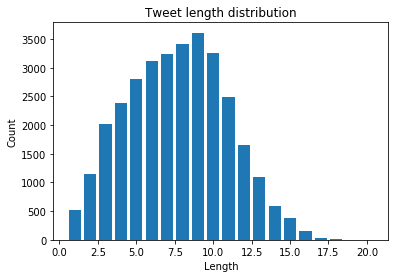

In [10]:
plt.bar(review_lens.keys(), review_lens.values())
plt.title("Tweet length distribution")
plt.xlabel("Length")
plt.ylabel("Count")


In [11]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [12]:
# Test your implementation!

seq_length = 17

features = pad_features(reviews_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[1])

[    0     0     0     0     0     0     0   103 10009  2110   468    19
  1298 10010 15658 15659 10011]


In [13]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx+1], features[split_idx-1:]
train_y, remaining_y = labels[:split_idx+1], labels[split_idx-1:]

print(len(remaining_x))
test_idx = int((len(remaining_x)-4)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx+4:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx+4:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

6394
			Feature Shapes:
Train set: 		(25570, 17) 
Validation set: 	(3195, 17) 
Test set: 		(3195, 17)


In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.asarray(train_x)), torch.from_numpy(np.asarray(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.asarray(val_x)), torch.from_numpy(np.asarray(val_y)))
test_data = TensorDataset(torch.from_numpy(np.asarray(test_x)), torch.from_numpy(np.asarray(test_y)))

# dataloaders
batch_size = 45

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [15]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([45, 17])
Sample input: 
 tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   394,  2956, 13914],
        [    0,     0,     0,   136,   118,    56,   390,     3,  1421,   306,
             8,   345,   218,   156,   143,  2052,  1968],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,   236,     8,  5766,    31,    72],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,   167,  1231, 13697,    63,  3289],
        [    0,     0,     0,     0,     0,     0,     0,  1807,  1463,     4,
           156,   628,  1663,  1521,  1402,    40,   405],
        [    0,     0,     0,     0,     0,  3564,   206,    34,   145,    44,
            57,     3,   289,   386,   166,   133,   299],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     6,
            26,    40, 15067,    58,

In [16]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [17]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [18]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 512
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(41709, 512)
  (lstm): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [19]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [20]:
# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()
#                 print(inputs.shape)
#                 print(labels.shape)

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.240972... Val Loss: 0.202621
Epoch: 2/4... Step: 200... Loss: 0.200948... Val Loss: 0.171935
Epoch: 3/4... Step: 300... Loss: 0.036225... Val Loss: 0.156296
Epoch: 4/4... Step: 400... Loss: 0.150362... Val Loss: 0.148040
Epoch: 4/4... Step: 500... Loss: 0.173673... Val Loss: 0.137059


In [21]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.167
Test accuracy: 0.952
